##Premier modèle :: LSTM (tensorflow)

### Lire les données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("darkgrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/inrae/icos/preprocessed_dataICOS.csv')
# data = pd.read_csv('../data/preprocessed_dataICOS.csv') si téléchargé depuis github
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.head()

In [ ]:
data.info()

### Préparation des données & helper functions

In [ ]:
df = data[['GPP_ann', 'GPP_cycle', 'anomalies', 'cos day','sin day','cos year', 'sin year']]
df.head()

In [ ]:
"""
fonction qui à partir du dataframe, crée des séquences sous forme de
[ [GPP_ann(t-L),GPP_cycle(t-L),anomalies(t-L),+time(t-L)], [GPP_ann(t-L+1),GPP_cycle(t-L+1),anomalies(t-L+1),+time(t-L+1)], ... ,
[GPP_ann(t),GPP_cycle(t),anomalies(t),+time(t)] ]
et des targets à t+1 : [GPP_ann(t+1), GPP_cycle(t+1), anomalies(t+1)]
avec L : longueur choisie de la séquence
l'intérêt d'avoir 3 sorties est d'évaluer chaque composante individuellemnt
"""
def inputs_outputs(sequence_length, data):
    data = np.array(data)
    sequences = []
    targets = []
    for i in range(0,len(data)-sequence_length-1):
        sequence = data[i:i+sequence_length] # variables d'intérêt de (t-L) à t + 4 remaining features(time), [GPP_ann,GPP_cycle,anomalies,+time ]
        target = data[i+sequence_length][:3] # variables d'intérêt à t+1 # [GPP_ann(t+1), GPP_cycle(t+1), anomalies(t+1)]
        sequences.append(sequence)
        targets.append(target)
    sequences = np.array(sequences)
    targets = np.array(targets)

    return sequences, targets

In [ ]:
sequence_length=365 # 7 jours
sequences, targets = inputs_outputs(sequence_length, df)

In [ ]:
sequences[0], targets[0]

In [ ]:
sequences.shape, targets.shape #seq_len=365, features=7

In [ ]:
# diviser le dataset en données d'entrainement et de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=19)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
import tensorflow.keras.backend as K

def weighted_loss(weights_matrix):
    def loss(y_true, y_pred):
        weighted_error = K.square(y_true - y_pred)*weights_matrix # choisir les composantes à prendre en compte et les composantes à ignorer (matrice binaire)
        return K.mean(weighted_error) # mse
    return loss

In [ ]:
weights_matrix_ann = [[1, 0, 0]]    # tenir compte de la composante annuelle
weights_matrix_cycle = [[0, 1, 0]]  # ............................. cycle
weights_matrix_anomalies = [[0, 0, 1]] # .......................... anomalies

# fonctions de loss personnalisés (pondérées)
loss_ann = weighted_loss(weights_matrix_ann)
loss_cycle = weighted_loss(weights_matrix_cycle)
loss_anomalies = weighted_loss(weights_matrix_anomalies)

## Modèle

 ### LSTM Tensorflow

In [16]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def mymodel(hidden_units, sequence_length, features, nbr_sorties):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(sequence_length,features), kernel_initializer='he_normal')) # initialisation poids: distribution normale he
    model.add(Dense(nbr_sorties))
    return model

In [ ]:
nbr_sorties = 3
hidden_units = 128
sequence_length = 365
features = 7
tf_model = mymodel(hidden_units, sequence_length, features, nbr_sorties)
tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 70,019
Trainable params: 70,019
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# arrêter l'entrainement si 5 epochs s'écoulent sans amélioration (pour éviter le over-fitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [18]:
# hyperparamètres
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
n_epochs = 100
batch_size = 32

#### Erreur sur la composante annuelle

In [ ]:
tf_model_ann = mymodel(hidden_units, sequence_length, features, nbr_sorties)

In [ ]:
tf_model_ann.compile(optimizer=optimizer, loss=loss_ann)

In [ ]:
history_ann = tf_model_ann.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
3002/3002 [==============================] - 46s 15ms/step - loss: 1.4071 - val_loss: 0.8702
Epoch 2/100
3002/3002 [==============================] - 43s 14ms/step - loss: 0.8382 - val_loss: 0.8346
Epoch 3/100
3002/3002 [==============================] - 43s 14ms/step - loss: 0.8108 - val_loss: 0.8680
Epoch 4/100
3002/3002 [==============================] - 53s 18ms/step - loss: 0.7958 - val_loss: 0.8178
Epoch 5/100
3002/3002 [==============================] - 45s 15ms/step - loss: 0.7844 - val_loss: 0.7946
Epoch 6/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.7795 - val_loss: 0.7974
Epoch 7/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.7729 - val_loss: 0.7946
Epoch 8/100
3002/3002 [==============================] - 44s 15ms/step - loss: 0.7693 - val_loss: 0.8001
Epoch 9/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.7619 - val_loss: 0.7807
Epoch 10/100
3002/3002 [==============================]

In [ ]:
tf_model_ann.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_ann.h5')

#### Erreur sur la composante du cycle

In [ ]:
tf_model_cycle = mymodel(hidden_units, sequence_length, features, nbr_sorties)

In [ ]:
tf_model_cycle.compile(optimizer=optimizer, loss=loss_cycle)

In [ ]:
history_cycle = tf_model_cycle.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
3002/3002 [==============================] - 45s 14ms/step - loss: 0.5956 - val_loss: 0.5107
Epoch 2/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.4623 - val_loss: 0.5006
Epoch 3/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.4114 - val_loss: 0.4225
Epoch 4/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3858 - val_loss: 0.3845
Epoch 5/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3639 - val_loss: 0.3798
Epoch 6/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3603 - val_loss: 0.3706
Epoch 7/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3512 - val_loss: 0.3843
Epoch 8/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3397 - val_loss: 0.3739
Epoch 9/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3344 - val_loss: 0.3626
Epoch 10/100
3002/3002 [==============================]

In [ ]:
tf_model_cycle.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_cycle.h5')

#### Erreur sur les anomalies

In [ ]:
tf_model_anomalies = mymodel(hidden_units, sequence_length, features, nbr_sorties)

In [ ]:
tf_model_anomalies.compile(optimizer=optimizer, loss=loss_anomalies)

In [ ]:
history_anomalies = tf_model_anomalies.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
3002/3002 [==============================] - 57s 17ms/step - loss: 2.6870 - val_loss: 2.5807
Epoch 2/100
3002/3002 [==============================] - 47s 16ms/step - loss: 2.5405 - val_loss: 2.5789
Epoch 3/100
3002/3002 [==============================] - 46s 15ms/step - loss: 2.5091 - val_loss: 2.5673
Epoch 4/100
3002/3002 [==============================] - 45s 15ms/step - loss: 2.4811 - val_loss: 2.5649
Epoch 5/100
3002/3002 [==============================] - 46s 15ms/step - loss: 2.4504 - val_loss: 2.5665
Epoch 6/100
3002/3002 [==============================] - 45s 15ms/step - loss: 2.4160 - val_loss: 2.5834
Epoch 7/100
3002/3002 [==============================] - 45s 15ms/step - loss: 2.3832 - val_loss: 2.5909
Epoch 8/100
3002/3002 [==============================] - 46s 15ms/step - loss: 2.3463 - val_loss: 2.5934
Epoch 9/100
3002/3002 [==============================] - 47s 16ms/step - loss: 2.3103 - val_loss: 2.6132


In [ ]:
tf_model_anomalies.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_anomalies.h5')

### Courbes loss

#### Cross year average

In [ ]:
train_loss = history_ann.history['loss']
val_loss = history_ann.history['val_loss']

In [ ]:
data_ann = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})
data_ann.head()

,Epochs,Training Loss,Validation Loss
0,1,1.407084,0.870183
1,2,0.838185,0.834567
2,3,0.810821,0.867958
3,4,0.795828,0.817820
4,5,0.784361,0.794628


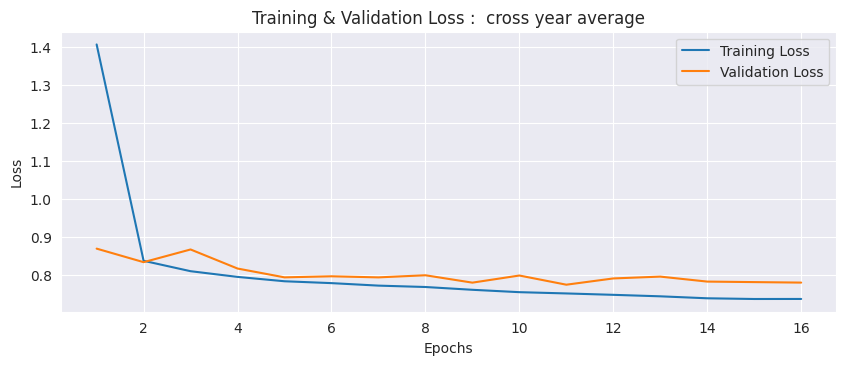

In [ ]:
plt.figure(figsize=(10, 8))

#Courbes loss, training vs validation
plt.subplot(2, 1, 1)
sns.lineplot(data=data_ann, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_ann, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  cross year average')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### day-and-night cycle

In [ ]:
train_loss = history_cycle.history['loss']
val_loss = history_cycle.history['val_loss']

data_cycle = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

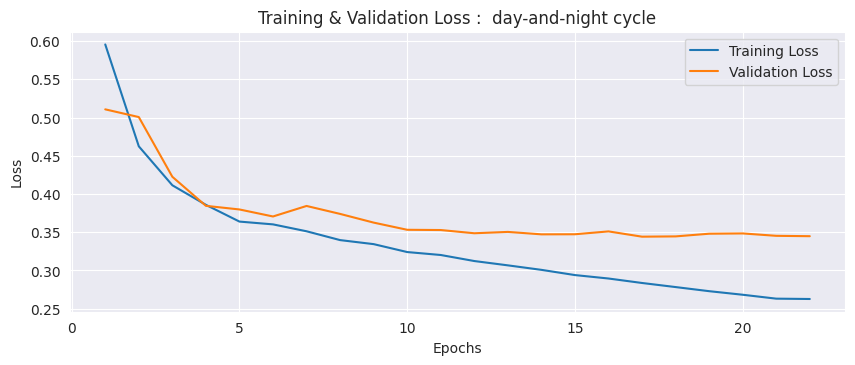

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_cycle, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_cycle, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  day-and-night cycle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### anomalies

In [ ]:
train_loss = history_anomalies.history['loss']
val_loss = history_anomalies.history['val_loss']

data_anomalies = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

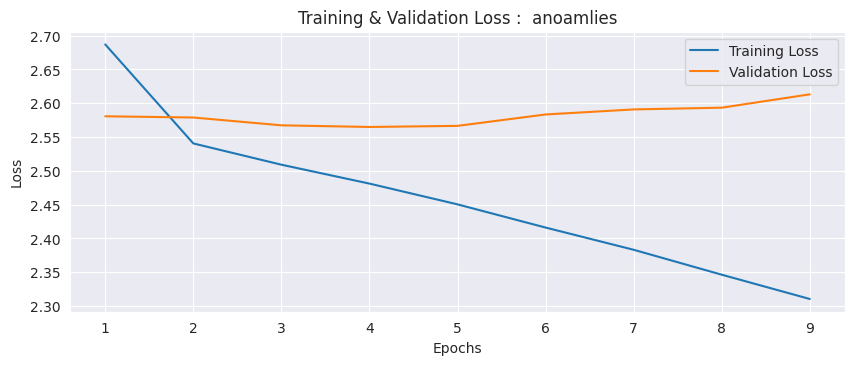

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_anomalies, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_anomalies, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  anoamlies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Continuer l'entrainement

La dernière fois, j'ai lancé les différents entrainements sur 100 époques en utilisant un critère d'arrêt précoce lorsque les performances (évaluées sur l'ensemble de validation) ne progressent plus. Maintenant, je vais poursuivre l'entraînement de ces modèles, mais cette fois avec une patience de 30. Les modèles enregistrés précédemment ont été entraînés respectivement sur 16 époques (pour l'erreur sur la composante annuelle), 22 époques (pour l'erreur sur le cycle) et 9 époques (pour l'erreur sur les anomalies).

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

#### Erreur sur la composante annuelle

In [ ]:
tf_model_ann = tf.keras.models.load_model('/content/drive/MyDrive/inrae/mymodels/tf_lstm_ann.h5',custom_objects={'loss': loss_ann})

In [ ]:
tf_model_ann.compile(optimizer=optimizer, loss=loss_ann)

In [ ]:
history_ann = tf_model_ann.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping],verbose=0)

In [ ]:
train_loss = history_ann.history['loss']
val_loss = history_ann.history['val_loss']

data_ann = pd.DataFrame({'Epochs': range(17, len(train_loss)+17),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

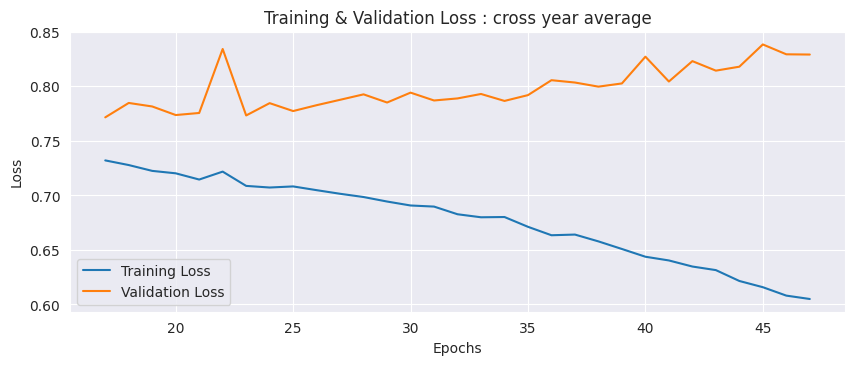

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_ann, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_ann, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss : cross year average')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
tf_model_ann.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_ann_47ep.h5')

#### Erreur sur la composante du cycle

In [20]:
tf_model_cycle = tf.keras.models.load_model('/content/drive/MyDrive/inrae/mymodels/tf_lstm_cycle.h5',custom_objects={'loss': loss_cycle})

In [21]:
tf_model_cycle.compile(optimizer=optimizer, loss=loss_cycle)

In [22]:
history_cycle = tf_model_cycle.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping], verbose=0)

In [23]:
train_loss = history_cycle.history['loss']
val_loss = history_cycle.history['val_loss']

data_cycle = pd.DataFrame({'Epochs': range(23, len(train_loss)+23),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

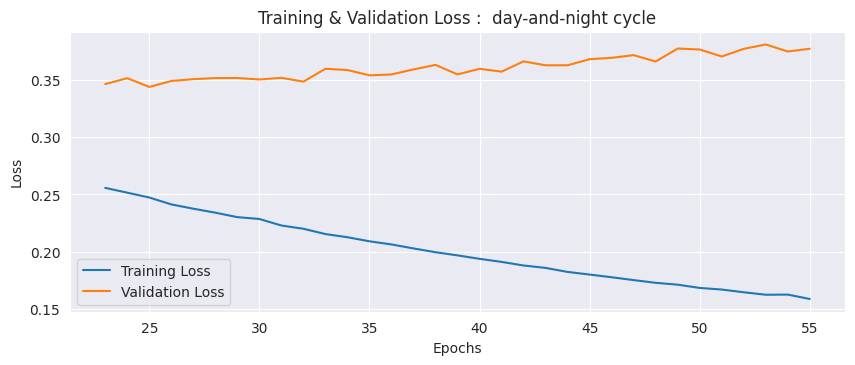

In [24]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_cycle, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_cycle, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  day-and-night cycle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
tf_model_cycle.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_cycle_55ep.h5')

#### Erreur sur les anomalies

In [ ]:
tf_model_anomalies = tf.keras.models.load_model('/content/drive/MyDrive/inrae/mymodels/tf_lstm_anomalies.h5',custom_objects={'loss': loss_anomalies})

In [ ]:
tf_model_anomalies.compile(optimizer='adam', loss=loss_anomalies)

In [ ]:
%time history_anomalies = tf_model_anomalies.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping],verbose=0)

CPU times: user 22min 18s, sys: 30.9 s, total: 22min 49s
Wall time: 21min 46s


In [ ]:
train_loss = history_anomalies.history['loss']
val_loss = history_anomalies.history['val_loss']

data_anomalies = pd.DataFrame({'Epochs': range(10, len(train_loss)+10),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

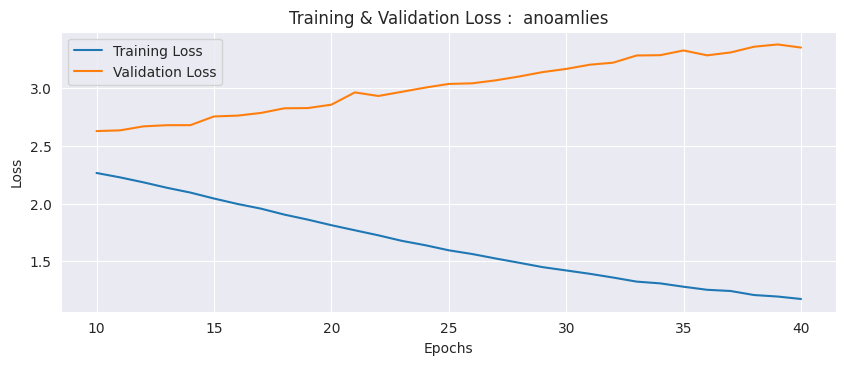

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_anomalies, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_anomalies, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  anoamlies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# globalement entrainé sur 9+31=40 époques
tf_model_anomalies.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_anomalies_40ep.h5')